<h1><center><center><h1><h1><center><span style="color:#2189b5">Flight Tickets Notebook </span><center><h1>

# My libraries 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from datetime import date

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn import preprocessing, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# My Figure size

In [2]:
from matplotlib import rcParams            
rcParams['figure.figsize'] = (20,10) 

# Remove warning

In [3]:
import warnings
warnings.simplefilter("ignore")

# My Dataset

In [4]:
test_ticket = pd.read_csv('Datasets/Test set.csv')
flight_ticket = pd.read_csv('Datasets/Train set.csv')
flight_ticket.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,9/06/2019,Kolkata,Banglore,CCU → BLR,14:25,16:55,2h 30m,non-stop,No info,5644
1,Vistara,6/03/2019,Mumbai,Hyderabad,BOM → DEL → HYD,08:45,09:25 07 Mar,24h 40m,1 stop,No info,12395
2,IndiGo,3/04/2019,Banglore,Delhi,BLR → DEL,06:05,08:50,2h 45m,non-stop,No info,4077
3,Vistara,12/06/2019,Kolkata,Banglore,CCU → DEL → BLR,17:00,23:25,6h 25m,1 stop,No info,8610
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → DEL,10:05,13:00,2h 55m,non-stop,No info,10067


<h1><center><span style="color:#2189b5">Exploring Data : </span><center><h1>

In [5]:
flight_ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8012 entries, 0 to 8011
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          8012 non-null   object
 1   Date_of_Journey  8012 non-null   object
 2   Source           8012 non-null   object
 3   Destination      8012 non-null   object
 4   Route            8011 non-null   object
 5   Dep_Time         8012 non-null   object
 6   Arrival_Time     8012 non-null   object
 7   Duration         8012 non-null   object
 8   Total_Stops      8011 non-null   object
 9   Additional_Info  8012 non-null   object
 10  Price            8012 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 688.7+ KB


In [6]:
print(Fore.LIGHTBLUE_EX + 'Number of Rows is : ', flight_ticket.shape[0])
print(Fore.LIGHTBLUE_EX + 'Number of columns is : ', flight_ticket.shape[1])

Number of Rows is :  8012
Number of columns is :  11


In [7]:
print(Fore.LIGHTBLUE_EX,'There is "{}" complete duplicate'.format(flight_ticket.duplicated().sum()))

 There is "125" complete duplicate


In [8]:
flight_ticket.describe()

,Price
count,8012.00
mean,9094.24
std,4571.79
min,1759.00
25%,5351.00
50%,8372.00
75%,12373.00
max,79512.00


### Showing rows that contains nan values : 

In [9]:
flight_ticket[flight_ticket.isna().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6879,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


### Displaying `min` and `max` days in the dataset : 

In [10]:
flight_ticket['Date_of_Journey'].agg(['min', 'max'])

min    01/03/2019
max     9/06/2019
Name: Date_of_Journey, dtype: object

## Ok !!! this shows as that all the dates are in 2019.

# Ok after exploring data I noticed many things :

> - dataframe has `8012 rows` and `11 columns`. <br><br>
> - There is `1 row` with nan values so I will drop it (1 row won't effect my data) <br><br>
> - There is `125 row with complete duplicates` so I will drop them as it is impossible that 2 plan flights with same time and duration and price and everything !!! <br><br>
> - `Date_of_Journey` column should be date and I noticed that all data is in 2019 <br><br>
> - `Dep_Time` and `Arrival_Time` columns are unclean as there is different formats in them so I will change both of them to date and I will display only hours and minutes <br><br>
> - I will make new columns of `Duration` where it will contain hours and minutes <br><br>

<h1><center><span style="color:#2189b5">Cleaning Data : </span><center><h1>

### I will remove year and I will make date by months and day only.

In [11]:
flight_ticket["Journey_day"] = pd.to_datetime(flight_ticket.Date_of_Journey, format="%d/%m/%Y").dt.day
flight_ticket["Journey_month"] = pd.to_datetime(flight_ticket["Date_of_Journey"], format = "%d/%m/%Y").dt.month
flight_ticket.drop(["Date_of_Journey"], axis = 1, inplace = True)

### I will make `Dep_Time` and `Arrival_Time` as 2 rows one for hours and other for minutes.

In [12]:
flight_ticket["Dep_hour"] = pd.to_datetime(flight_ticket["Dep_Time"]).dt.hour
flight_ticket["Dep_min"] = pd.to_datetime(flight_ticket["Dep_Time"]).dt.minute
flight_ticket.drop(["Dep_Time"], axis = 1, inplace = True)

flight_ticket["Arrival_hour"] = pd.to_datetime(flight_ticket.Arrival_Time).dt.hour
flight_ticket["Arrival_min"] = pd.to_datetime(flight_ticket.Arrival_Time).dt.minute
flight_ticket.drop(["Arrival_Time"], axis = 1, inplace = True)

### And so I will do for duration (I will split it to hours and minutes).

In [13]:
def get_duration(x):
    x=x.split(' ')
    hours=0
    mins=0
    if len(x)==1:
        x=x[0]
        if x[-1]=='h':
            hours=int(x[:-1])
        else:
            mins=int(x[:-1])
    else:
        hours=int(x[0][:-1])
        mins=int(x[1][:-1])
    return hours,mins

flight_ticket['Duration_hours']=flight_ticket['Duration'].apply(lambda x:get_duration(x)[0])
flight_ticket['Duration_mins']=flight_ticket['Duration'].apply(lambda x:get_duration(x)[1])

flight_ticket.drop(["Duration"], axis = 1, inplace = True)

## Checking for wrong data : 

In [14]:
unclean_row = flight_ticket[(flight_ticket['Duration_hours'] == 0) & (flight_ticket['Duration_mins'] < 30)]
unclean_row

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
3680,Air India,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,2 stops,No info,17327,6,3,16,50,16,55,0,5


## This means that there is a row where duration is 5m only !! I will drop it.

In [15]:
flight_ticket.drop(unclean_row.index,axis=0,inplace=True)

### Since that Total_steps gives data about Route... then I will remove Route column.

In [16]:
flight_ticket.drop('Route',axis=1,inplace=True)

## I will remove the only row with Nan values and I will remove duplicates.

In [17]:
flight_ticket.dropna(inplace=True)
flight_ticket.drop_duplicates(inplace=True)

In [18]:
flight_ticket

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Kolkata,Banglore,non-stop,No info,5644,9,6,14,25,16,55,2,30
1,Vistara,Mumbai,Hyderabad,1 stop,No info,12395,6,3,8,45,9,25,24,40
2,IndiGo,Banglore,Delhi,non-stop,No info,4077,3,4,6,5,8,50,2,45
3,Vistara,Kolkata,Banglore,1 stop,No info,8610,12,6,17,0,23,25,6,25
4,IndiGo,Banglore,New Delhi,non-stop,No info,10067,1,3,10,5,13,0,2,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,IndiGo,Delhi,Cochin,1 stop,No info,7503,24,5,18,35,1,30,6,55
8008,IndiGo,Mumbai,Hyderabad,non-stop,No info,4049,6,5,9,10,10,40,1,30
8009,Air Asia,Kolkata,Banglore,1 stop,No info,5162,9,4,6,50,10,30,3,40
8010,SpiceJet,Chennai,Kolkata,non-stop,No check-in baggage included,3332,21,3,9,30,12,5,2,35


<h1><center><span style="color:#2189b5">Visualizing Data : </span><center><h1>

### Here I want to see how does `Airline`,`Source`,`Destination` and `Total_Stops` columns effects the `Price` :

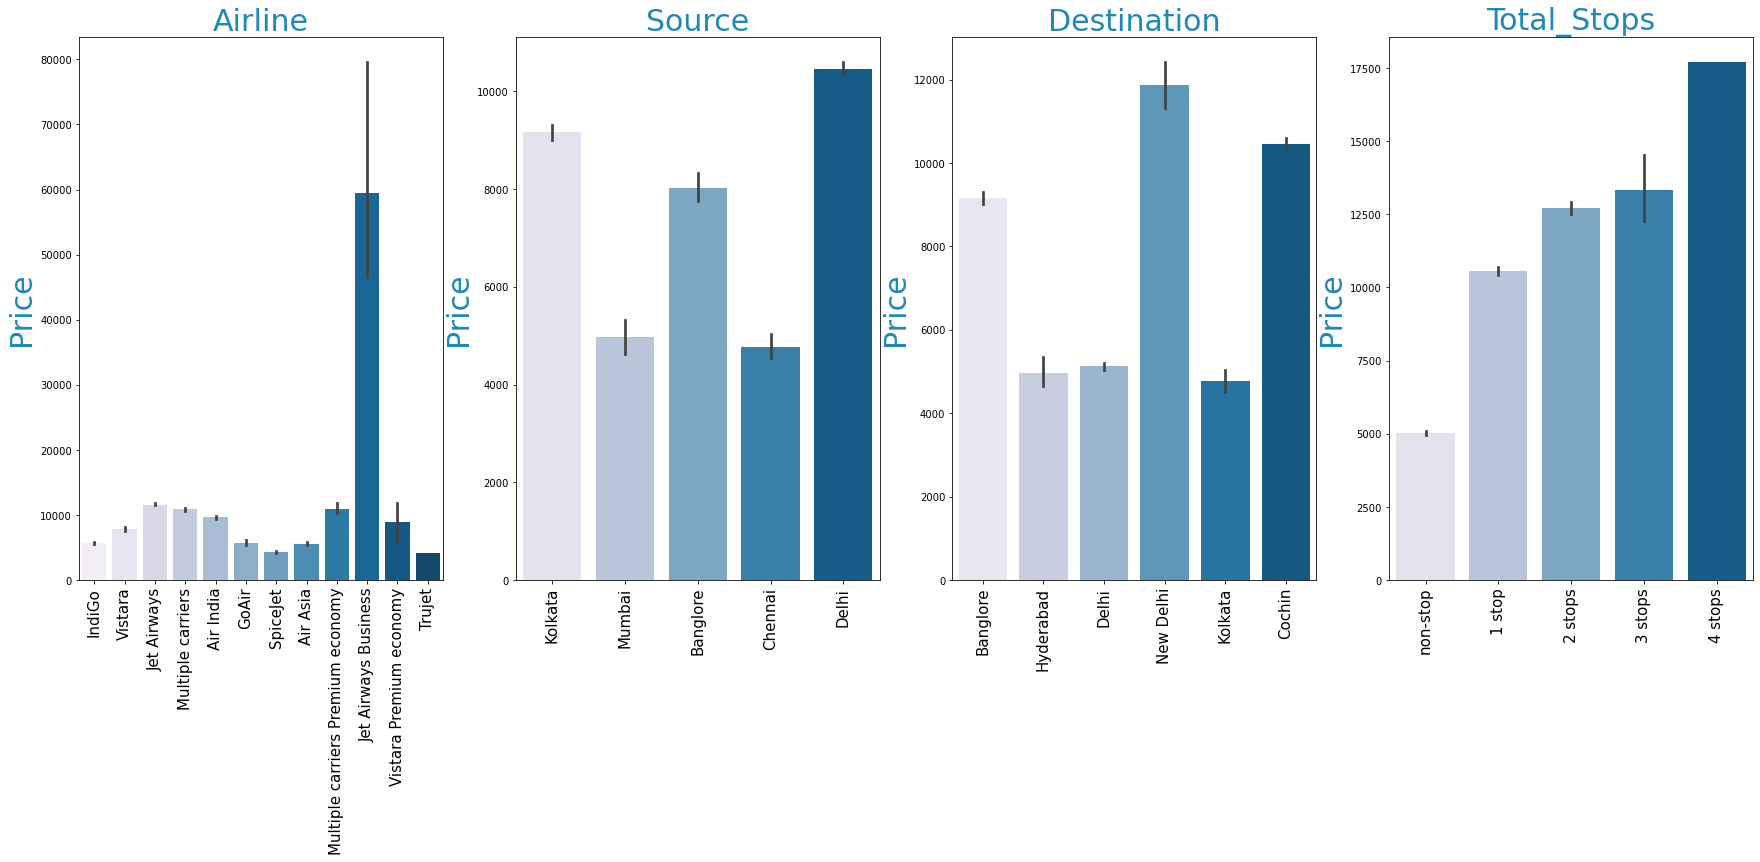

In [19]:
my_cols = ['Airline','Source','Destination','Total_Stops']

fig = plt.figure(figsize=(30,10))

counter = 0

for i in my_cols:
    
    sub = fig.add_subplot(1,4,counter+1)
    g = sns.barplot(x=i,y='Price',data=flight_ticket,palette='PuBu')
    
    plt.xticks(rotation=90,size=15)
    plt.title(i,size=30,color='#2189b5')
    plt.xlabel('')
    plt.ylabel('Price',size=30,color='#2189b5')
    
    counter = counter + 1

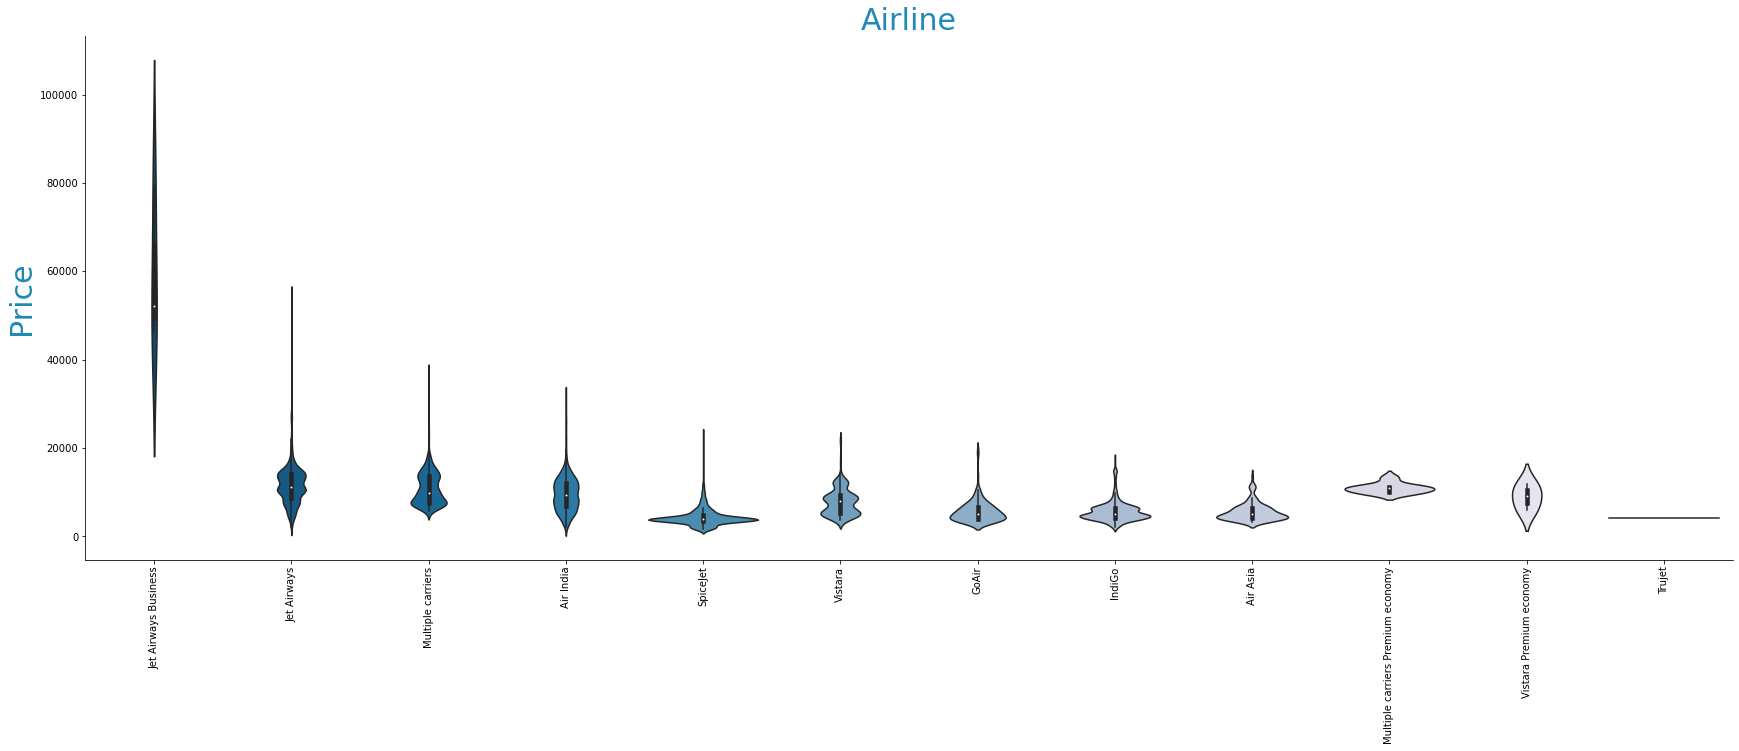

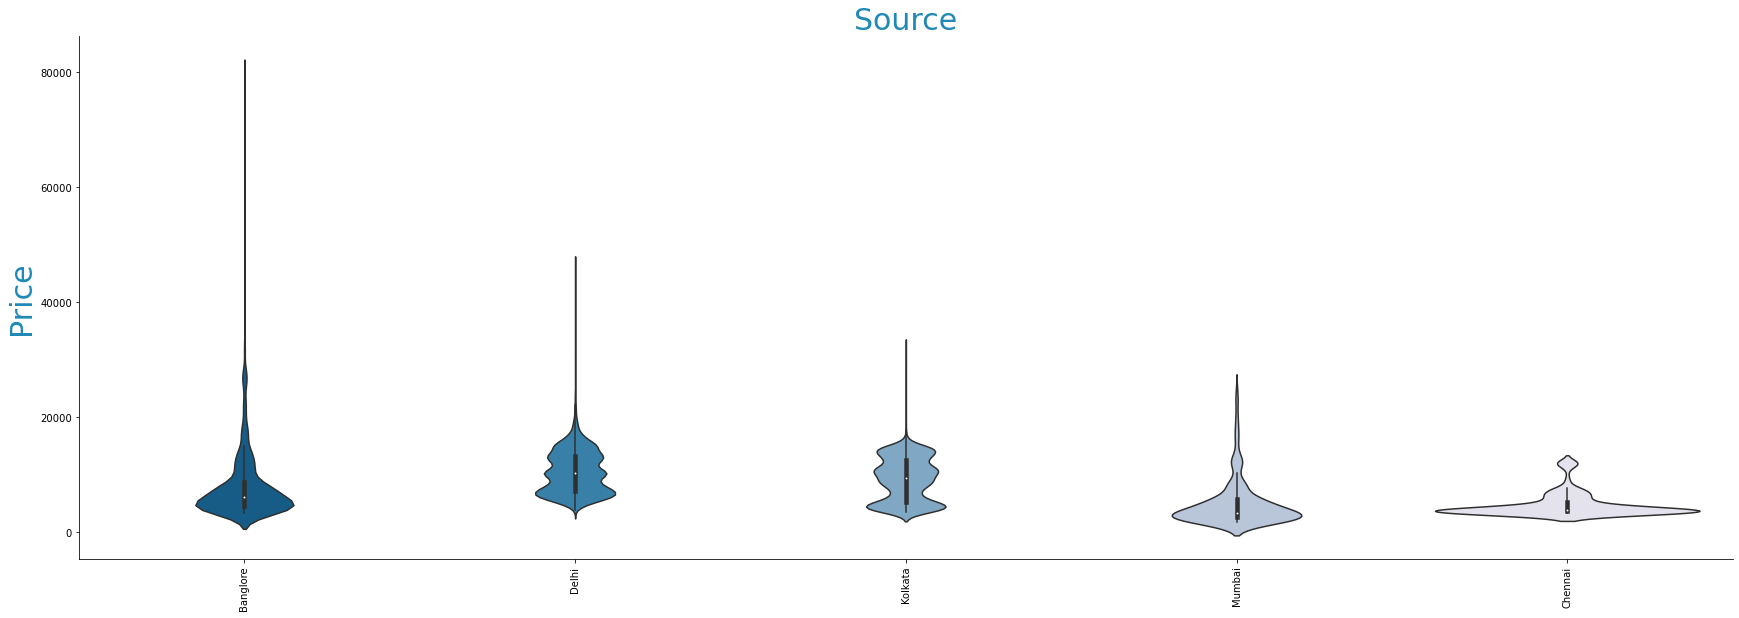

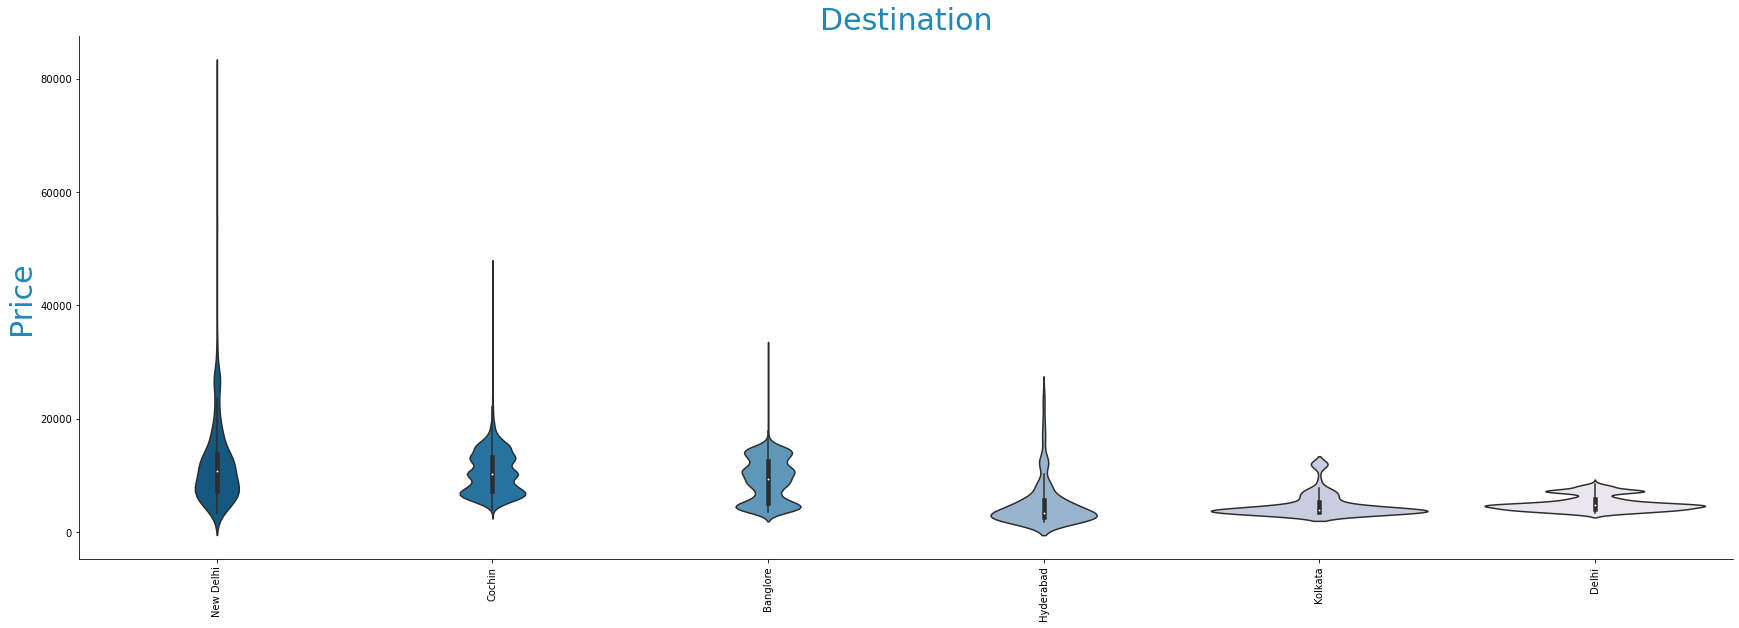

In [20]:
for i in ['Airline','Source','Destination']:
    
    sns.catplot(y = "Price", x = i, data = flight_ticket.sort_values("Price", ascending = False), kind="violin",
            height = 8, aspect = 3, palette='PuBu_r')
    
    plt.xticks(rotation=90)
    plt.title(i,size=30,color='#2189b5')
    plt.ylabel('Price',size=30,color='#2189b5')
    plt.xlabel('')
    
    plt.show()

## Ok in the previous plots I showed how `Airline`,`Source`,`Destination` and `Total_Stops` effects `Price` using barplot <br><br> Where the bar is at the average price and the line is the variation using standerd deviation
### What I noticed from the previous plot is :
> - Using Google search I now knew that all this cities are in `india` <br><br>
> - `Jet Airways Buisiness` has the highest average price and highest deviation (from 45k to 80k) <br><br>
> - Relative to the `source` the price changes !! (if the flight from `Delhi` that will cost max price) <br><br>
> - Relative to the `Destination` the price changes <br><br>
> - By increasing number of `Total_Stops` the `Price` increase

### Now I will show how `additional info` relates to `Price` : 

In [21]:
def visualizing_additional_info():
    
    ## This code will only be used for arranging order for the plot :
    
    summaries = {'Price':'mean'}
    grouped = flight_ticket.groupby(by = flight_ticket['Additional_Info']).agg(summaries)
    grouped_by_price = grouped.sort_values('Price')
    my_order = grouped_by_price.index

    ## making the plot : 
    
    g = sns.barplot(y='Additional_Info',x='Price',data=flight_ticket,palette='PuBu',order=my_order)
    
    plt.xticks(rotation=90,size=15)
    plt.title('Additional info',size=30,color='#2189b5')
    plt.xlabel('Price',size=30,color='#2189b5')
    plt.ylabel('')

    plt.show()

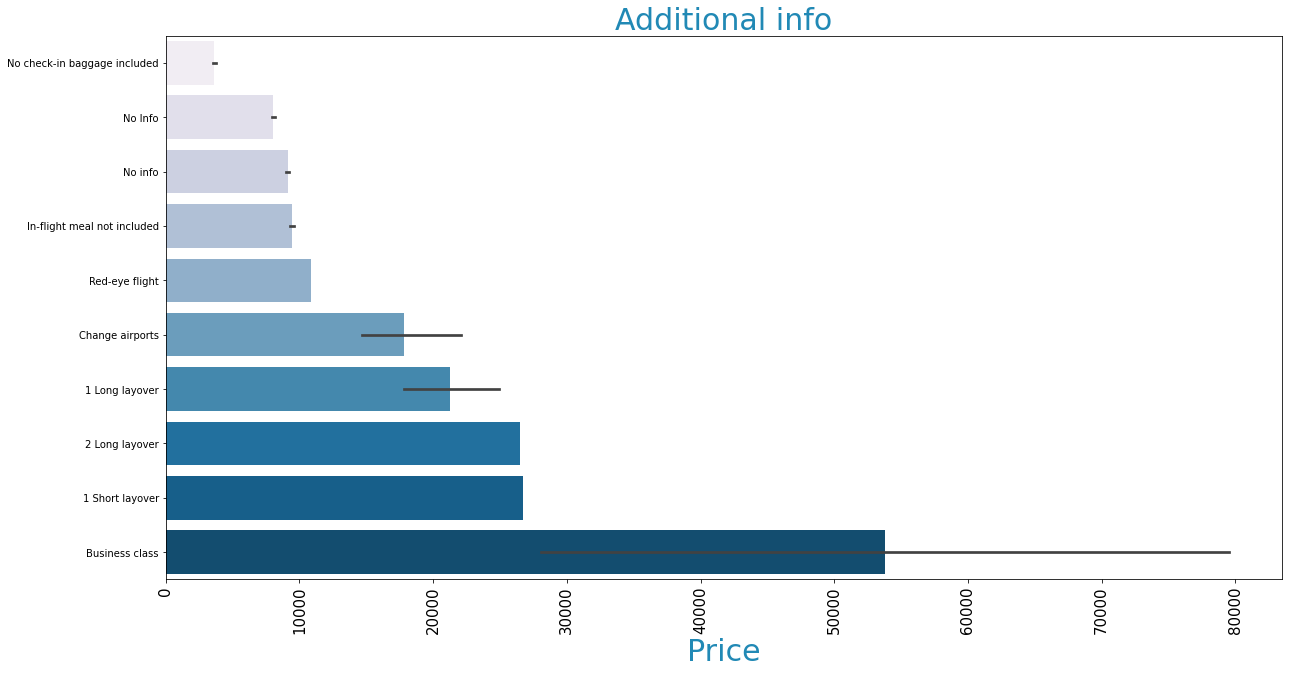

In [22]:
visualizing_additional_info()


## I can notice that there is 2 data with name no info so I will clean that 

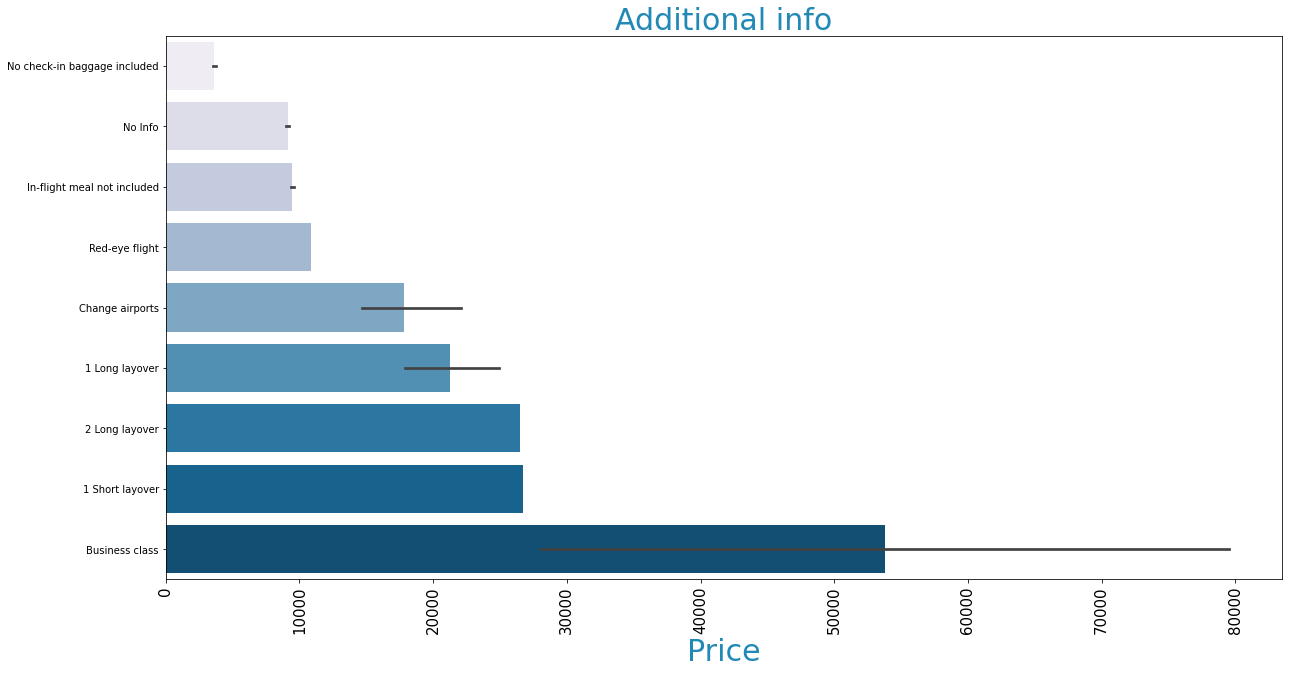

In [23]:
flight_ticket['Additional_Info'].replace('No info','No Info',inplace=True)

visualizing_additional_info()

## Insights I got from previous plot : 
> - `Buisness` class has high variation <br><br>
> - `price` is significantly effected by the `info` of the data

### Plotting Bar chart for `Journey_month` vs `Number of Flights` : 

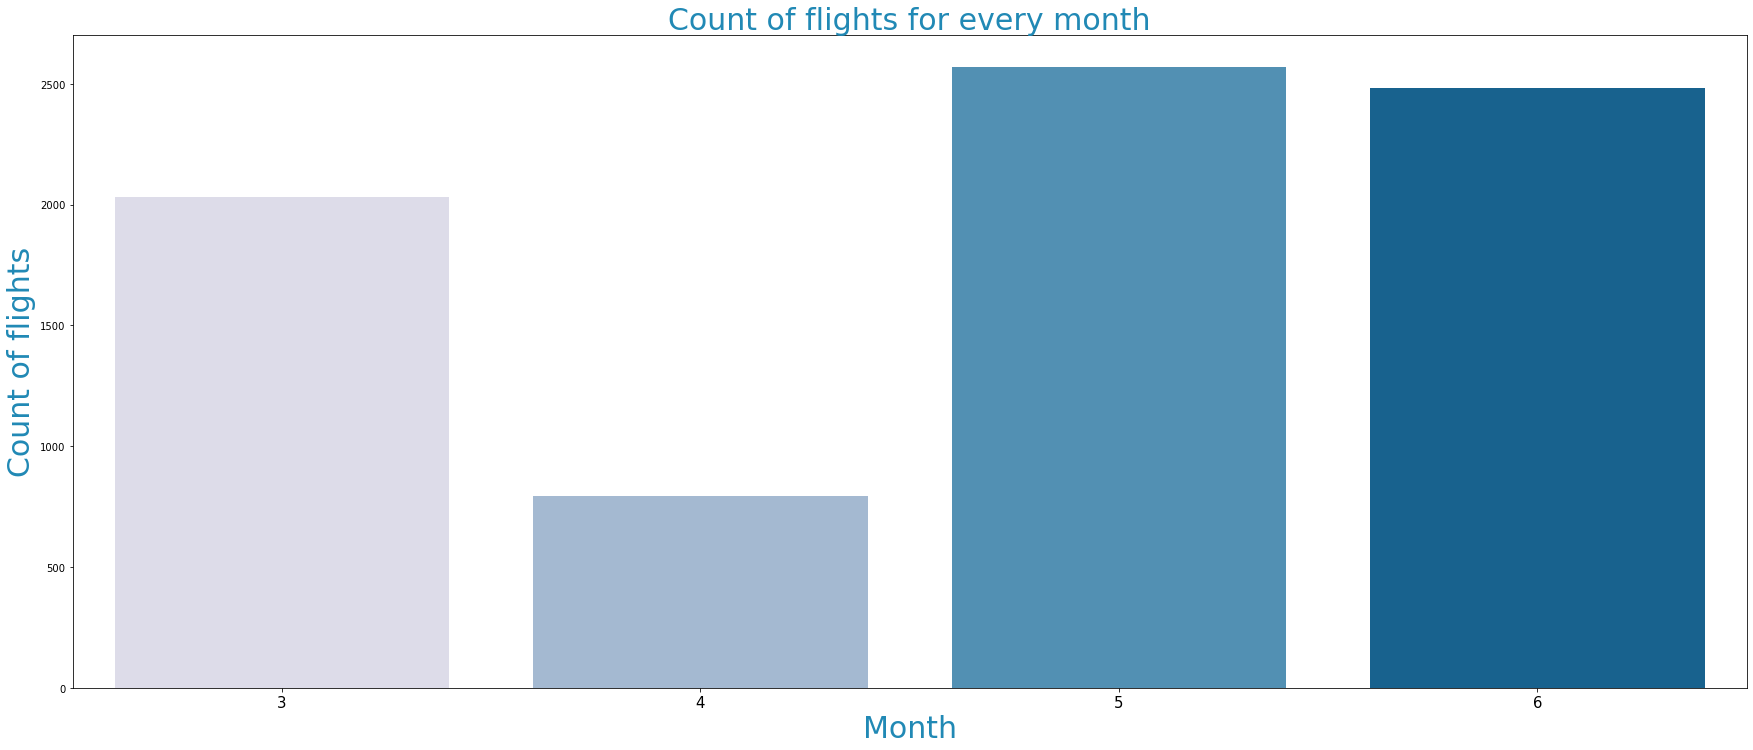

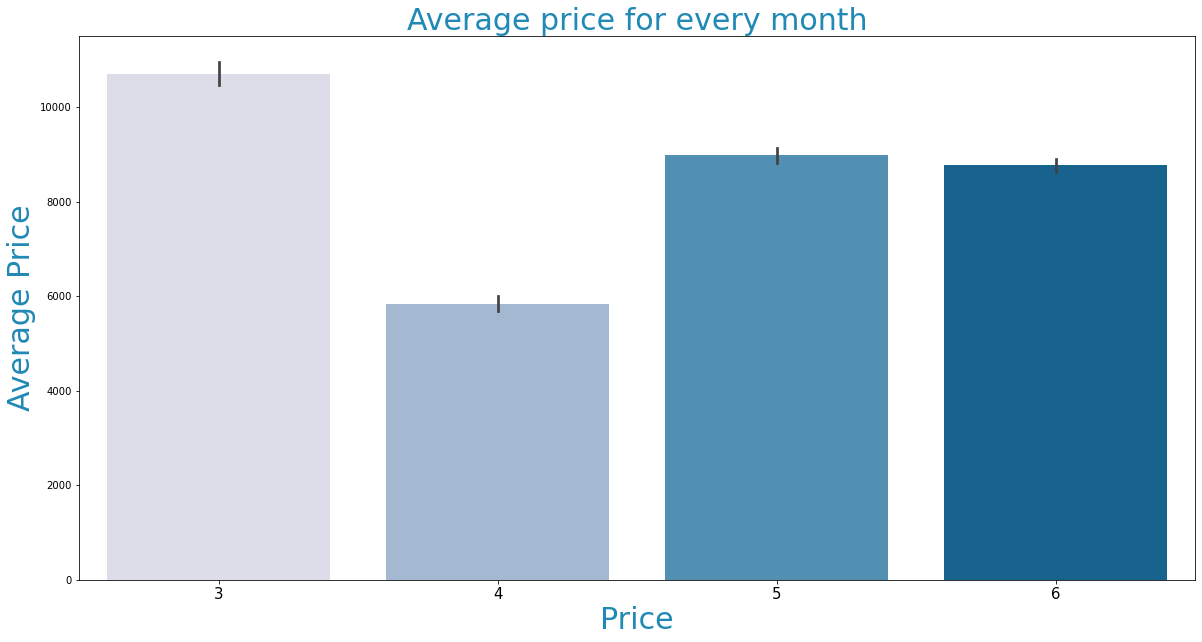

In [24]:
fig = plt.figure(figsize=(30,12))


ax=sns.countplot(x = 'Journey_month', data = flight_ticket, palette='PuBu')

plt.xlabel('Month',size=30,color='#2189b5')
plt.ylabel('Count of flights',size=30,color='#2189b5')
plt.title('Count of flights for every month',size=30,color='#2189b5')
plt.xticks(size=15)

plt.show()

ax = sns.barplot(y='Price',x='Journey_month',data=flight_ticket,palette='PuBu')
    
plt.xticks(size=15)
plt.title('Average price for every month',size=30,color='#2189b5')
plt.xlabel('Price',size=30,color='#2189b5')
plt.ylabel('Average Price',size=30,color='#2189b5')

plt.show()

## Insights I got from previous graph : 
> - Most travels are at `May (5)` <br><br>
> - Highest tickets average prices is at `March (3)` <br><br>
> - Highest tickets deviation in prices is at `March (3)`

## Now I want to show how the duration of the flight affects the Price:
### So I will make a new feature and I will name it as `Total_duration_minutes` 

In [25]:
flight_ticket['Total_duration_minutes'] = (flight_ticket['Duration_hours'] * 60) + (flight_ticket['Duration_mins'])

In [26]:
flight_ticket.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Total_duration_minutes
0,IndiGo,Kolkata,Banglore,non-stop,No Info,5644,9,6,14,25,16,55,2,30,150
1,Vistara,Mumbai,Hyderabad,1 stop,No Info,12395,6,3,8,45,9,25,24,40,1480
2,IndiGo,Banglore,Delhi,non-stop,No Info,4077,3,4,6,5,8,50,2,45,165
3,Vistara,Kolkata,Banglore,1 stop,No Info,8610,12,6,17,0,23,25,6,25,385
4,IndiGo,Banglore,New Delhi,non-stop,No Info,10067,1,3,10,5,13,0,2,55,175


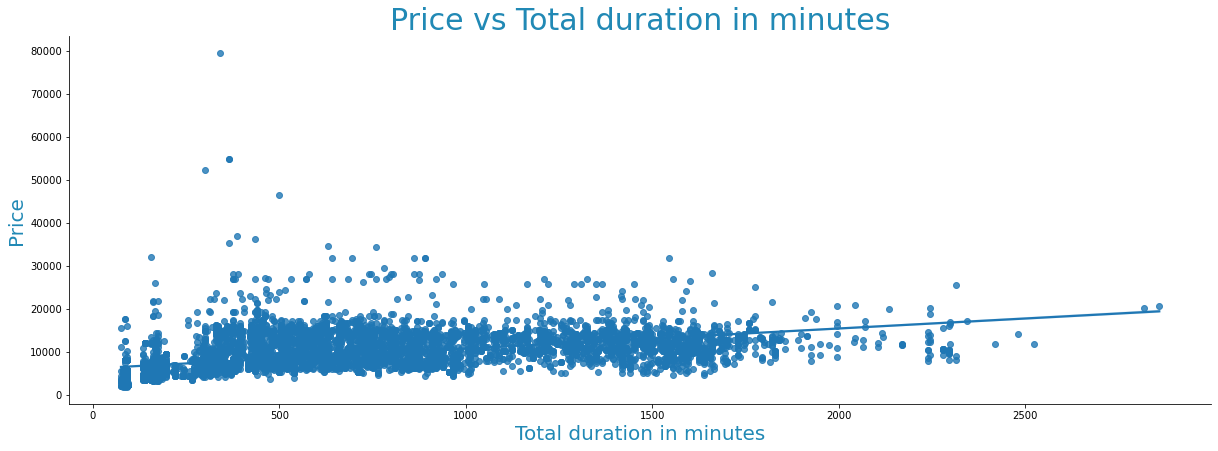

In [27]:
g = sns.lmplot(x ='Total_duration_minutes', y ='Price', data = flight_ticket, palette='PuBu')

g.fig.set_figwidth(20)
g.fig.set_figheight(6)

plt.xlabel('Total duration in minutes',size=20,color='#2189b5')
plt.ylabel('Price',size=20,color='#2189b5')
plt.title('Price vs Total duration in minutes',size=30,color='#2189b5')


plt.show()

## Quite disappointing I think :(

### I will make same previous plot but I will add some dimensions to take more insights...

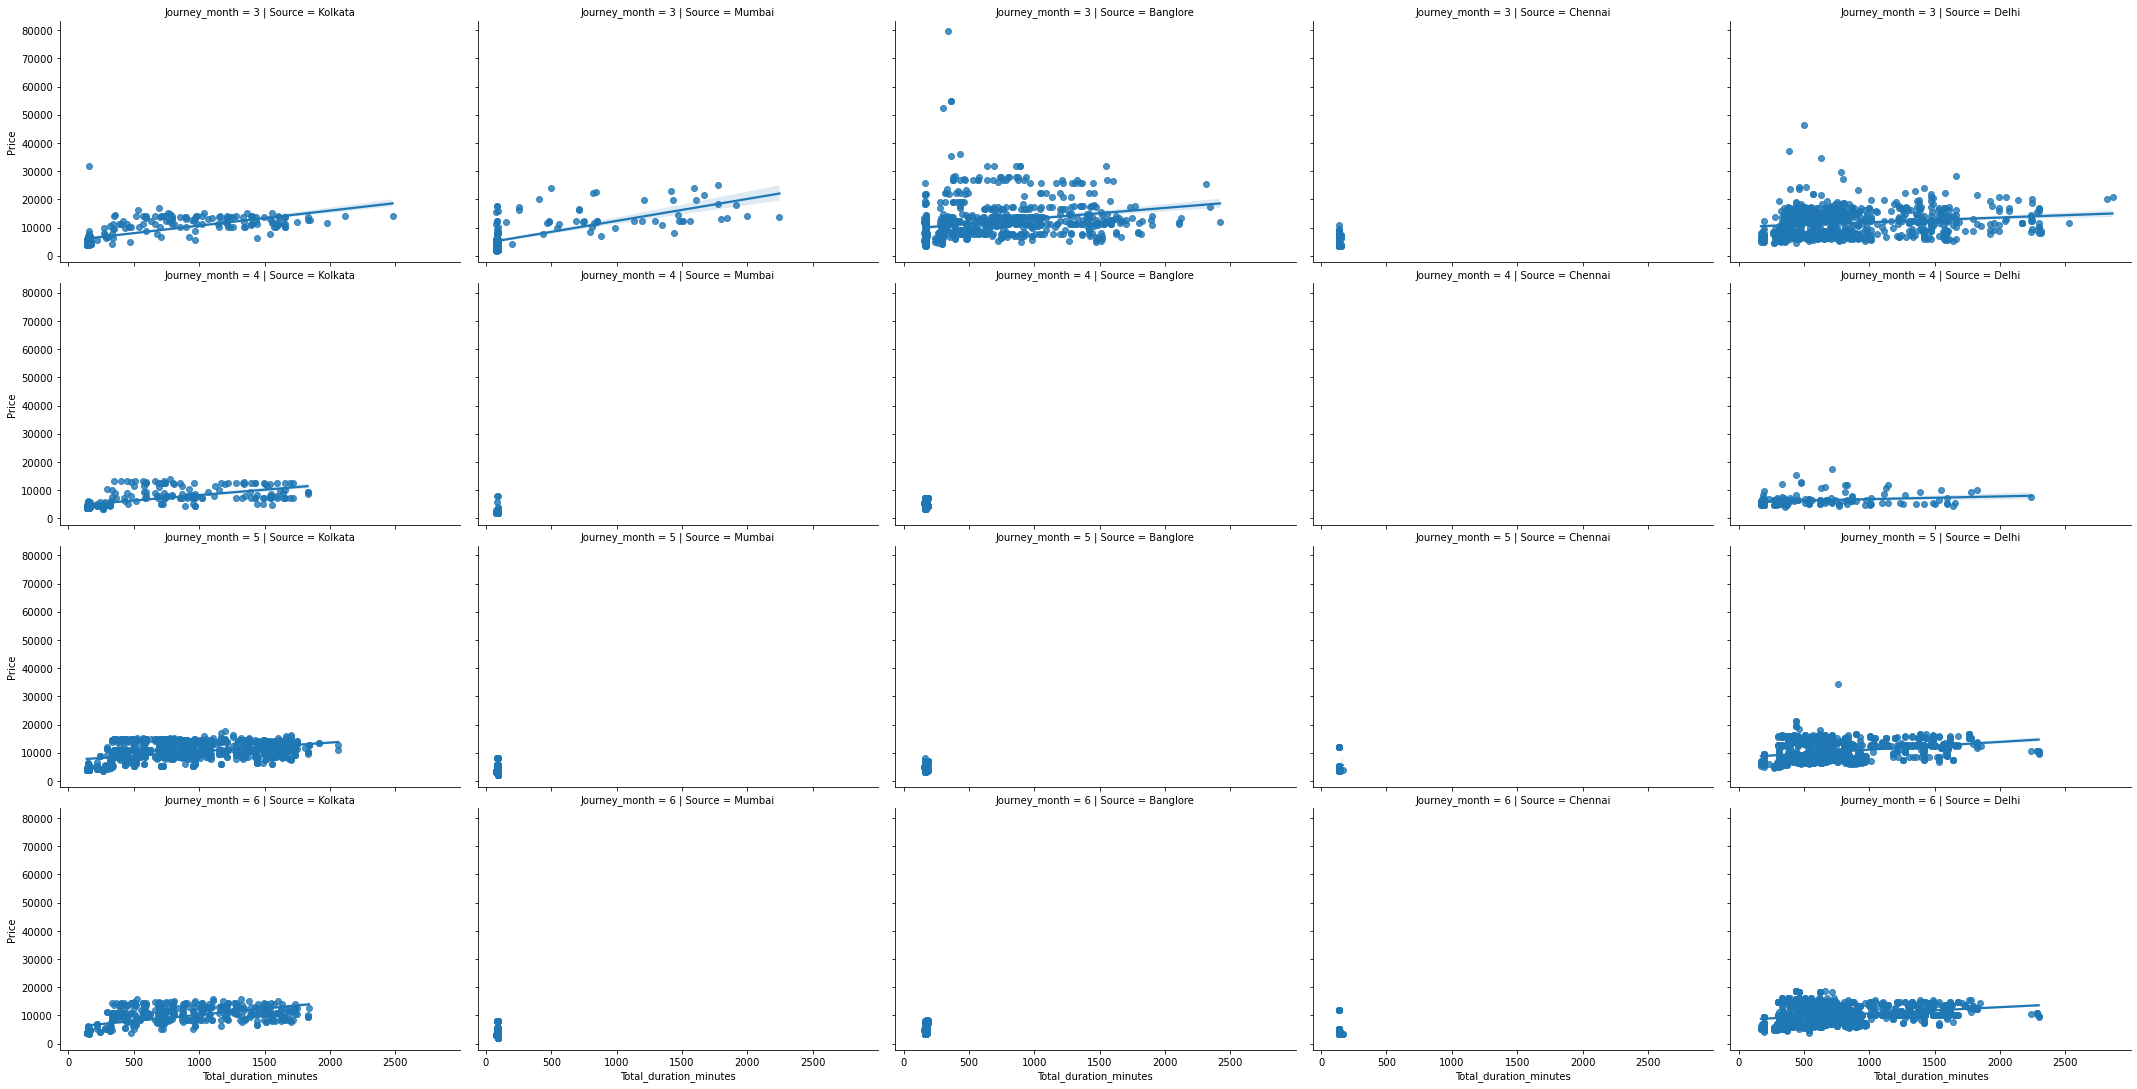

In [28]:
g = sns.lmplot(x ='Total_duration_minutes', y ='Price', data = flight_ticket, palette='PuBu',
               row='Journey_month', col='Source')

g.fig.set_figwidth(30)
g.fig.set_figheight(15)


plt.show()

### Plotting destination with the source and how they effects the price : 

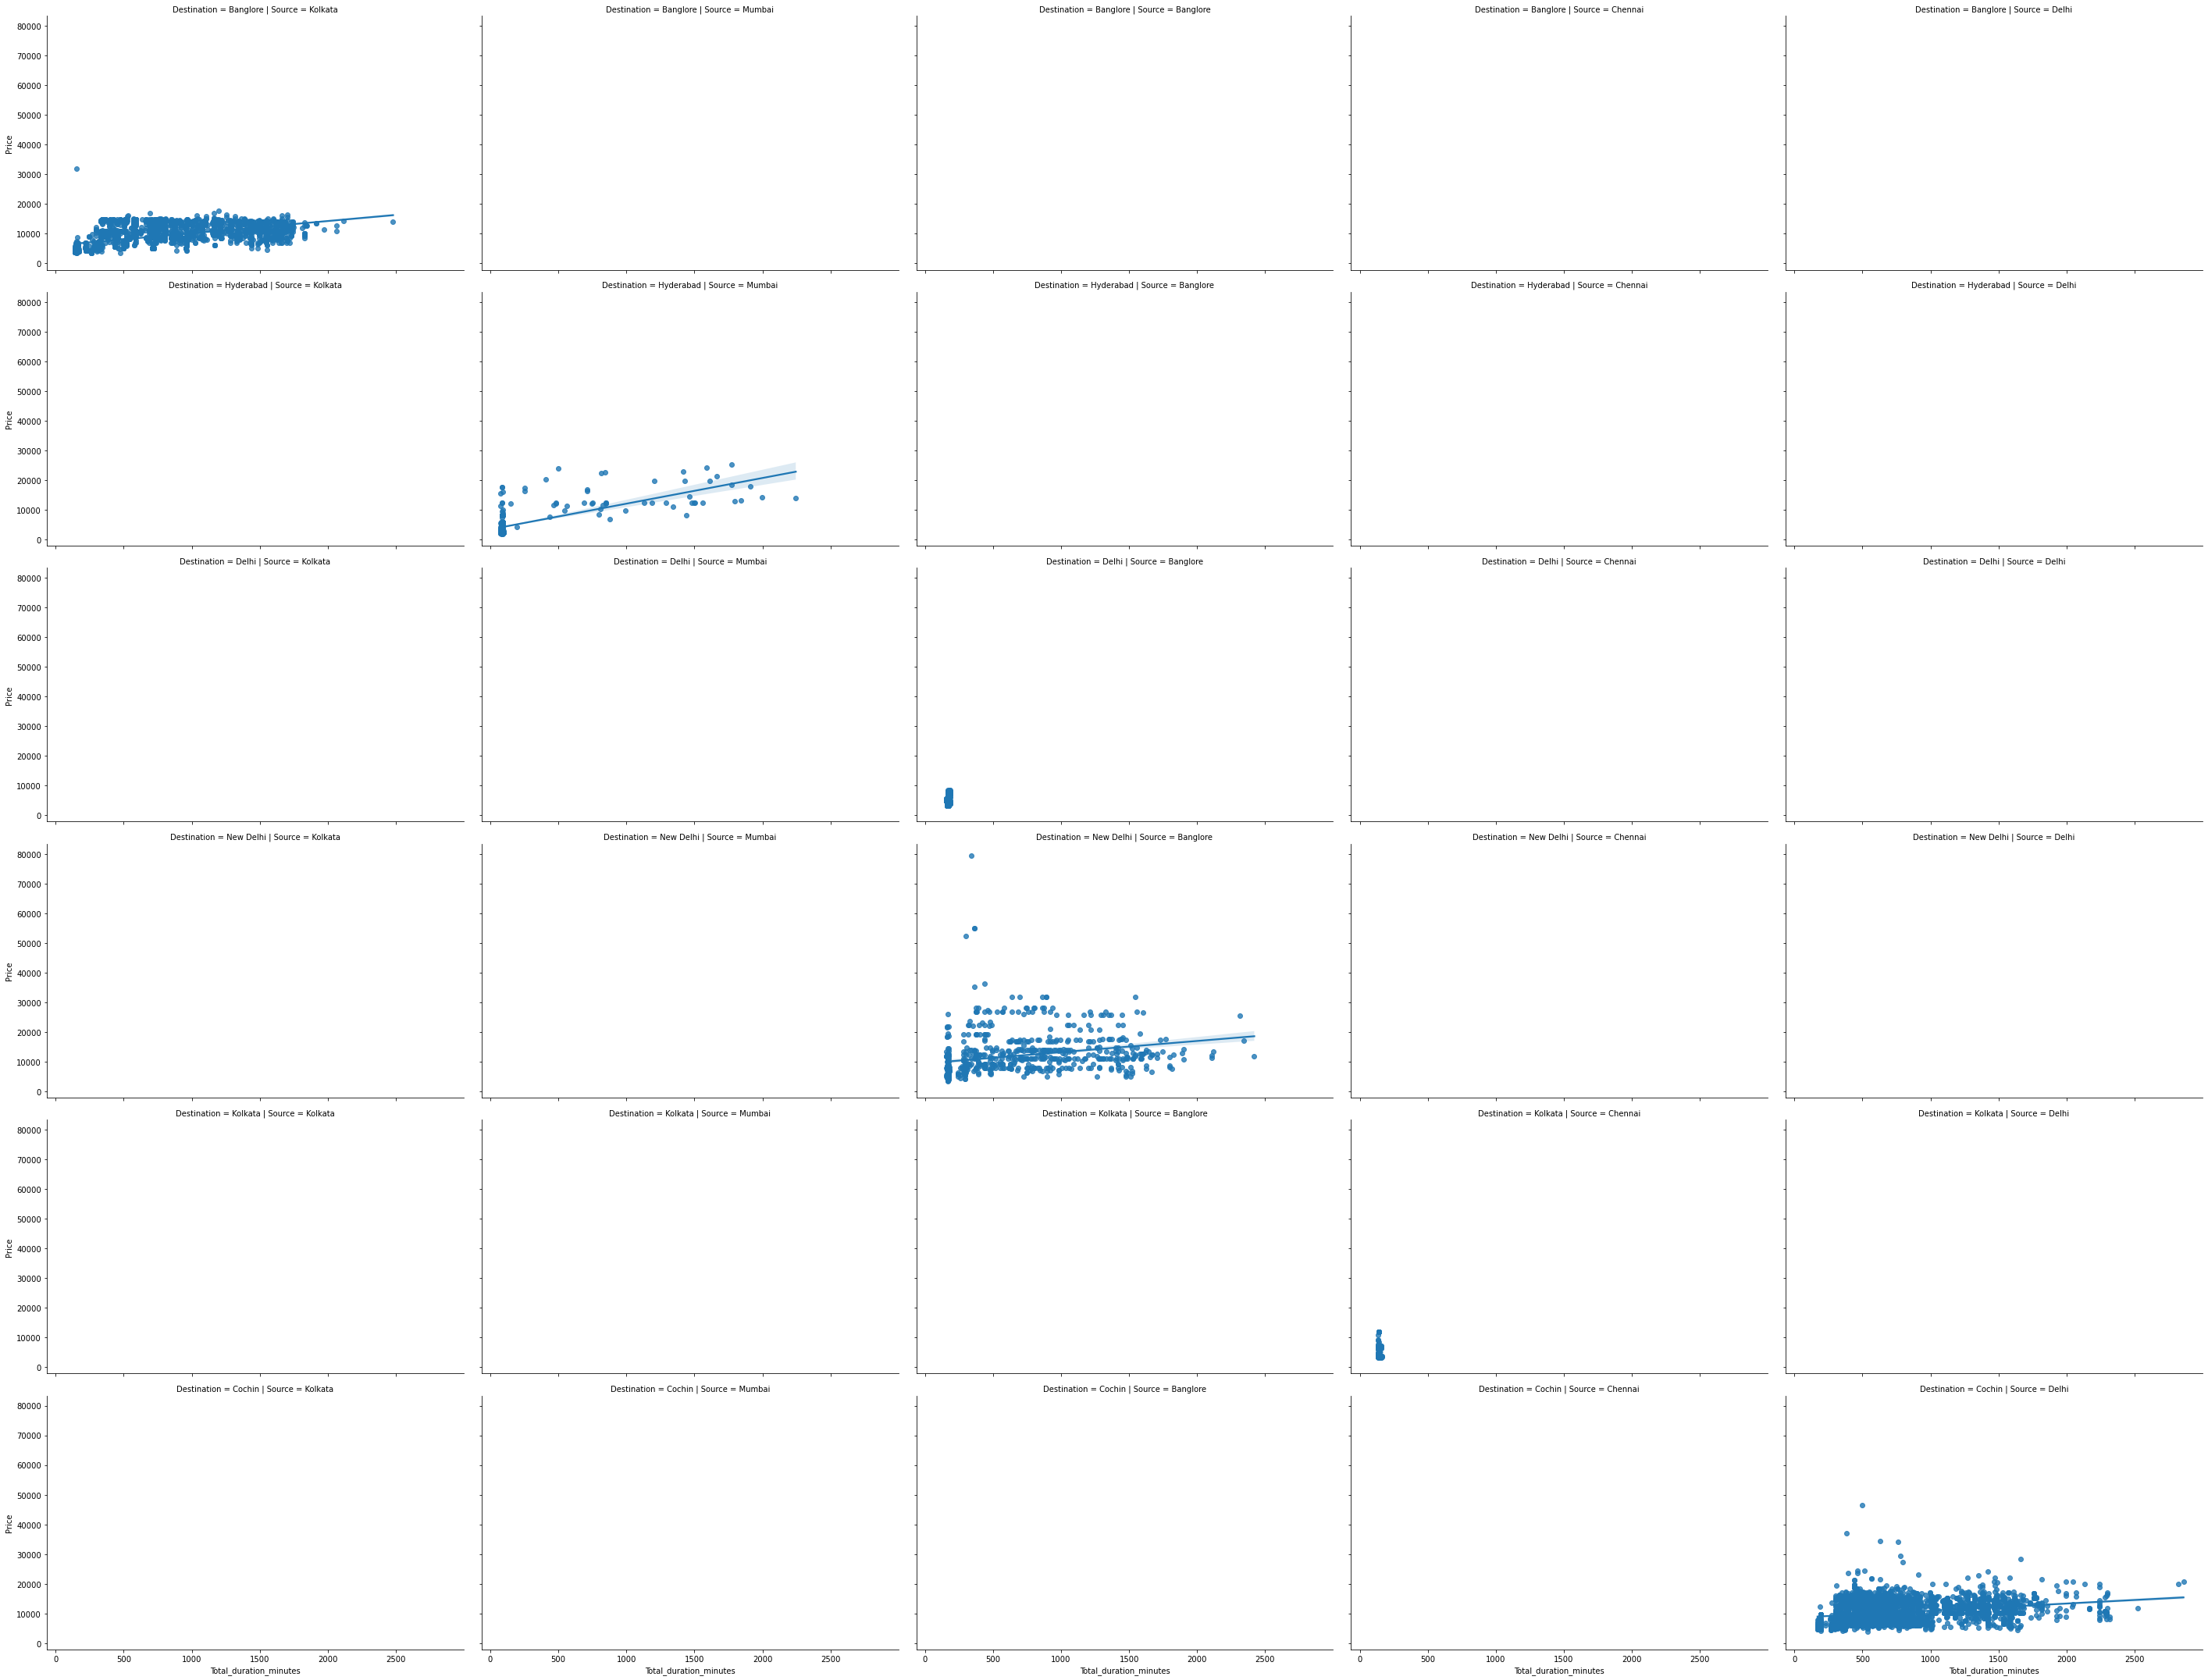

In [29]:
g = sns.lmplot(x ='Total_duration_minutes', y ='Price', data = flight_ticket, palette='PuBu',
               row='Destination', col='Source')

g.fig.set_figwidth(40)
g.fig.set_figheight(30)


plt.show()

## Ok Now I know that data won't have a strong linear correlation... also I can't see there is other obvious polynomial correlations and there is no curves to fit such shapes (So I think Linear regression will be a bad choice Model)

## To be more sure I will make a matrix of correlations :

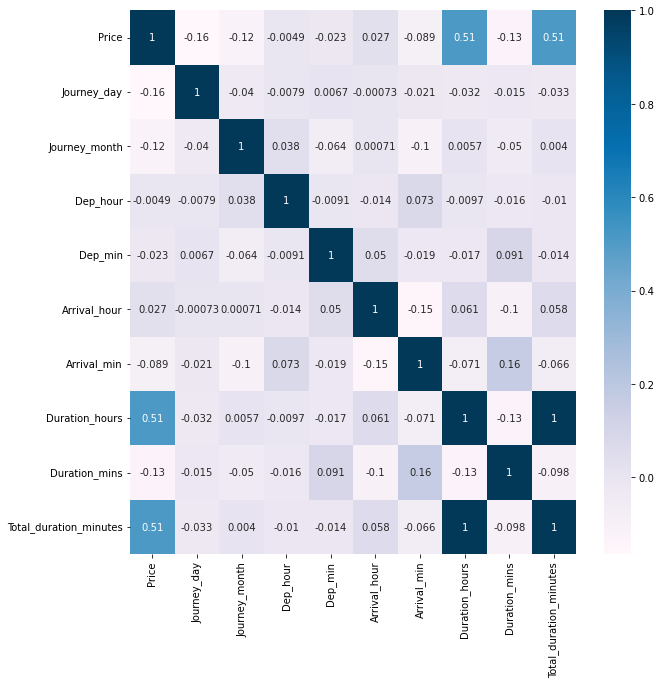

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(flight_ticket.corr(), annot = True, cmap = "PuBu")
plt.show()

## since strong correlations is at (coff > 0.7).... here there is no values much correlated with each other 
## Only duration_hour column has coff = 1 with total minutes and that is because they are the same column (I made them for cleaning and testing the ML model)

### I know that corr coef shows linear coefficents only but with the visualizations I didn't notice any other curve to fit..

<h1><center><span style="color:#2189b5">Making Training And Testing datasets ready : </span><center><h1>

## This code will copy modifications of train dataset to test dataset :

In [31]:
test_ticket["Journey_day"] = pd.to_datetime(test_ticket.Date_of_Journey, format="%d/%m/%Y").dt.day
test_ticket["Journey_month"] = pd.to_datetime(test_ticket["Date_of_Journey"], format = "%d/%m/%Y").dt.month
test_ticket.drop(["Date_of_Journey"], axis = 1, inplace = True)

test_ticket["Dep_hour"] = pd.to_datetime(test_ticket["Dep_Time"]).dt.hour
test_ticket["Dep_min"] = pd.to_datetime(test_ticket["Dep_Time"]).dt.minute
test_ticket.drop(["Dep_Time"], axis = 1, inplace = True)

test_ticket["Arrival_hour"] = pd.to_datetime(test_ticket.Arrival_Time).dt.hour
test_ticket["Arrival_min"] = pd.to_datetime(test_ticket.Arrival_Time).dt.minute
test_ticket.drop(["Arrival_Time"], axis = 1, inplace = True)

def get_duration(x):
    x=x.split(' ')
    hours=0
    mins=0
    if len(x)==1:
        x=x[0]
        if x[-1]=='h':
            hours=int(x[:-1])
        else:
            mins=int(x[:-1])
    else:
        hours=int(x[0][:-1])
        mins=int(x[1][:-1])
    return hours,mins

test_ticket['Duration_hours']=test_ticket['Duration'].apply(lambda x:get_duration(x)[0])
test_ticket['Duration_mins']=test_ticket['Duration'].apply(lambda x:get_duration(x)[1])

test_ticket.drop(["Duration"], axis = 1, inplace = True)

test_ticket.drop('Route',axis=1,inplace=True)

test_ticket['Total_duration_minutes'] = (test_ticket['Duration_hours'] * 60) + (test_ticket['Duration_mins'])

In [32]:
test_ticket.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Total_duration_minutes
0,Air India,Kolkata,Banglore,2 stops,No info,9,5,9,25,13,45,28,20,1700
1,Air Asia,Banglore,Delhi,non-stop,No info,24,5,11,10,13,55,2,45,165
2,Air India,Kolkata,Banglore,non-stop,No info,12,4,14,15,16,45,2,30,150
3,Jet Airways,Delhi,Cochin,1 stop,In-flight meal not included,27,5,17,30,12,35,19,5,1145
4,Jet Airways,Kolkata,Banglore,1 stop,In-flight meal not included,6,5,17,0,18,0,25,0,1500


# Ok Now training dataset is same as testing !!!
## What I want to do now is encoding `Airline`,`Source` and `Destination` as 0 and 1 <br><br>And spreading them using `to_dummy` function (this will increase accuracy of model !!)

In [33]:
to_dummy_train = flight_ticket[['Airline','Source','Destination']]
to_dummy_test = test_ticket[['Airline','Source','Destination']]
to_dummy = pd.concat([to_dummy_train,to_dummy_test])

### I concatenated two dataframes together to make changes take place in both dataframes

In [34]:
to_dummy.head()

,Airline,Source,Destination
0,IndiGo,Kolkata,Banglore
1,Vistara,Mumbai,Hyderabad
2,IndiGo,Banglore,Delhi
3,Vistara,Kolkata,Banglore
4,IndiGo,Banglore,New Delhi


In [35]:
changed_flight = flight_ticket[::]
changed_test = test_ticket[::]

### I will make new modifies on `changed_flight` and `changed_test` 
### `flight_ticket` will be used only for visualizing 

In [36]:
changed_flight = flight_ticket[::]
changed_test = test_ticket[::]

In [37]:
Airline = to_dummy[["Airline"]]
Airline = pd.get_dummies(Airline)
Source = to_dummy[["Source"]]
Source = pd.get_dummies(Source)
Destination = to_dummy[["Destination"]]
Destination = pd.get_dummies(Destination)

In [38]:
changed_flight.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Total_duration_minutes
0,IndiGo,Kolkata,Banglore,non-stop,No Info,5644,9,6,14,25,16,55,2,30,150
1,Vistara,Mumbai,Hyderabad,1 stop,No Info,12395,6,3,8,45,9,25,24,40,1480
2,IndiGo,Banglore,Delhi,non-stop,No Info,4077,3,4,6,5,8,50,2,45,165
3,Vistara,Kolkata,Banglore,1 stop,No Info,8610,12,6,17,0,23,25,6,25,385
4,IndiGo,Banglore,New Delhi,non-stop,No Info,10067,1,3,10,5,13,0,2,55,175


In [39]:
changed_test.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Total_duration_minutes
0,Air India,Kolkata,Banglore,2 stops,No info,9,5,9,25,13,45,28,20,1700
1,Air Asia,Banglore,Delhi,non-stop,No info,24,5,11,10,13,55,2,45,165
2,Air India,Kolkata,Banglore,non-stop,No info,12,4,14,15,16,45,2,30,150
3,Jet Airways,Delhi,Cochin,1 stop,In-flight meal not included,27,5,17,30,12,35,19,5,1145
4,Jet Airways,Kolkata,Banglore,1 stop,In-flight meal not included,6,5,17,0,18,0,25,0,1500


## Making `to_dummy` to split columns : 

In [40]:
airline_col = ['airline1','airline2','airline3','airline4'
              ,'airline5','airline6','airline7','airline8'
              ,'airline9','airline10','airline11','airline12'
              ]

source_col = ['source1','source2','source3','source4','source5']

destination_col = ['destination1','destination2','destination3'
                  ,'destination4','destination5','destination6'
                  ]

changed_flight[airline_col] = Airline[0:7883]
changed_flight.drop('Airline',axis=1,inplace=True)

changed_flight[source_col] = Source[0:7883]
changed_flight.drop('Source',axis=1,inplace=True)

changed_flight[destination_col] = Destination[0:7883]
changed_flight.drop('Destination',axis=1,inplace=True)

changed_test[airline_col] = Airline[7883::]
changed_test.drop('Airline',axis=1,inplace=True)

changed_test[source_col] = Source[7883::]
changed_test.drop('Source',axis=1,inplace=True)

changed_test[destination_col] = Destination[7883::]
changed_test.drop('Destination',axis=1,inplace=True)

In [41]:
changed_flight.head()

,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,...,source2,source3,source4,source5,destination1,destination2,destination3,destination4,destination5,destination6
0,non-stop,No Info,5644,9,6,14,25,16,55,2,...,0,0,1,0,1,0,0,0,0,0
1,1 stop,No Info,12395,6,3,8,45,9,25,24,...,0,0,0,1,0,0,0,1,0,0
2,non-stop,No Info,4077,3,4,6,5,8,50,2,...,0,0,0,0,0,0,1,0,0,0
3,1 stop,No Info,8610,12,6,17,0,23,25,6,...,0,0,1,0,1,0,0,0,0,0
4,non-stop,No Info,10067,1,3,10,5,13,0,2,...,0,0,0,0,0,0,0,0,0,1


In [42]:
changed_test.head()

,Total_Stops,Additional_Info,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,source2,source3,source4,source5,destination1,destination2,destination3,destination4,destination5,destination6
0,2 stops,No info,9,5,9,25,13,45,28,20,...,0,0,1,0,1,0,0,0,0,0
1,non-stop,No info,24,5,11,10,13,55,2,45,...,0,0,0,0,0,0,1,0,0,0
2,non-stop,No info,12,4,14,15,16,45,2,30,...,0,0,1,0,1,0,0,0,0,0
3,1 stop,In-flight meal not included,27,5,17,30,12,35,19,5,...,0,1,0,0,0,1,0,0,0,0
4,1 stop,In-flight meal not included,6,5,17,0,18,0,25,0,...,0,0,1,0,1,0,0,0,0,0


## Now I need to encode categorical data for both training and testing datasets :

### Ok... To do so I will make a new dataframe consisting of the concatination of both first 5 columns of training and testing
### So I will encode them together... to give them the same encoding.

In [43]:
to_encode_train = changed_flight[['Total_Stops','Additional_Info']]
to_encode_test = changed_test[['Total_Stops','Additional_Info']]
to_encode = pd.concat([to_encode_train,to_encode_test])

le = preprocessing.LabelEncoder()

for i in to_encode:
     to_encode[i]=le.fit_transform(to_encode[i])

In [44]:
to_encode.head()

,Total_Stops,Additional_Info
0,4,6
1,0,6
2,4,6
3,0,6
4,4,6


#### Now my data is fully encoded....

In [45]:
to_encode_train = to_encode[0:7883]
to_encode_test = to_encode[7883::]

changed_flight[['Total_Stops','Additional_Info']] = to_encode_train
changed_test[['Total_Stops','Additional_Info']] = to_encode_test

In [46]:
changed_flight.head()

,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,...,source2,source3,source4,source5,destination1,destination2,destination3,destination4,destination5,destination6
0,4,6,5644,9,6,14,25,16,55,2,...,0,0,1,0,1,0,0,0,0,0
1,0,6,12395,6,3,8,45,9,25,24,...,0,0,0,1,0,0,0,1,0,0
2,4,6,4077,3,4,6,5,8,50,2,...,0,0,0,0,0,0,1,0,0,0
3,0,6,8610,12,6,17,0,23,25,6,...,0,0,1,0,1,0,0,0,0,0
4,4,6,10067,1,3,10,5,13,0,2,...,0,0,0,0,0,0,0,0,0,1


In [47]:
changed_test.head()

,Total_Stops,Additional_Info,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,source2,source3,source4,source5,destination1,destination2,destination3,destination4,destination5,destination6
0,1,8,9,5,9,25,13,45,28,20,...,0,0,1,0,1,0,0,0,0,0
1,4,8,24,5,11,10,13,55,2,45,...,0,0,0,0,0,0,1,0,0,0
2,4,8,12,4,14,15,16,45,2,30,...,0,0,1,0,1,0,0,0,0,0
3,0,5,27,5,17,30,12,35,19,5,...,0,1,0,0,0,1,0,0,0,0
4,0,5,6,5,17,0,18,0,25,0,...,0,0,1,0,1,0,0,0,0,0


## Now my test data has the same formats of training.... and both training and testing are fully encoded (Now they are ready) :) <br><br><br><br><br>

<h1><center><span style="color:#2189b5">Data Optimization Using Statistics : </span><center><h1>

## Here I will use `statistical` approches to make my data ready for the Machine Learning Model. <br>
## same steps will be done on both `train` and `testing` data sets

### Checking data skewness :

In [48]:
flight_ticket.skew()

Price                     1.72
Journey_day               0.12
Journey_month            -0.38
Dep_hour                  0.10
Dep_min                   0.17
Arrival_hour             -0.39
Arrival_min               0.11
Duration_hours            0.88
Duration_mins            -0.09
Total_duration_minutes    0.89
dtype: float64

In [49]:
test_ticket.skew()

Journey_day               0.12
Journey_month            -0.39
Dep_hour                  0.14
Dep_min                   0.16
Arrival_hour             -0.32
Arrival_min               0.12
Duration_hours            0.86
Duration_mins            -0.09
Total_duration_minutes    0.87
dtype: float64

# Visualizing Skewness : 

<Figure size 1440x720 with 0 Axes>

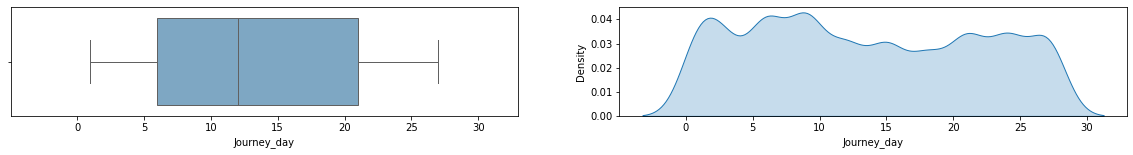

<Figure size 1440x144 with 0 Axes>

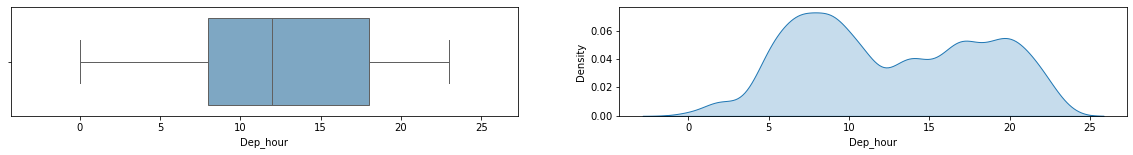

<Figure size 1440x144 with 0 Axes>

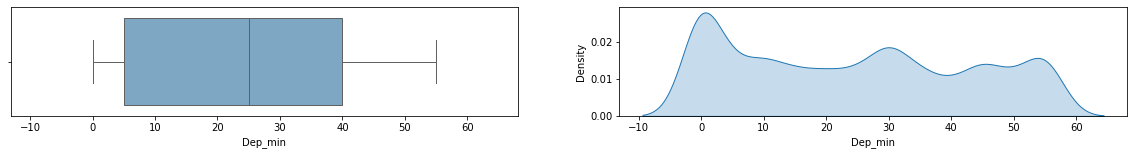

<Figure size 1440x144 with 0 Axes>

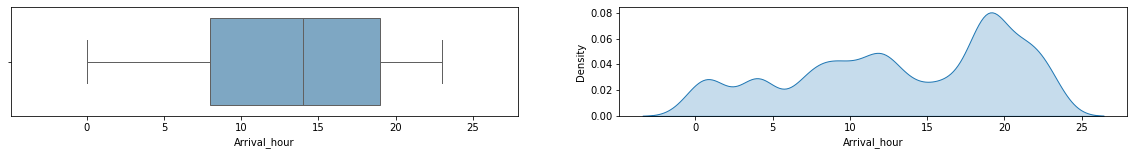

<Figure size 1440x144 with 0 Axes>

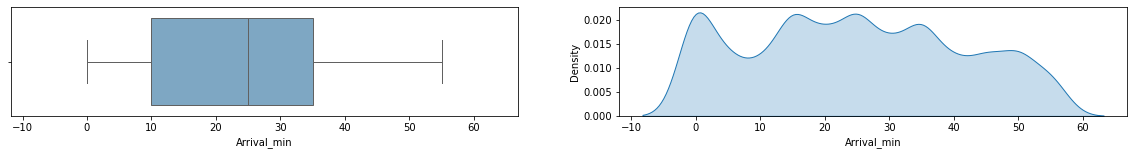

<Figure size 1440x144 with 0 Axes>

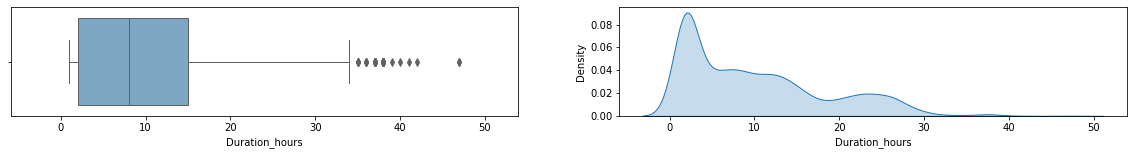

<Figure size 1440x144 with 0 Axes>

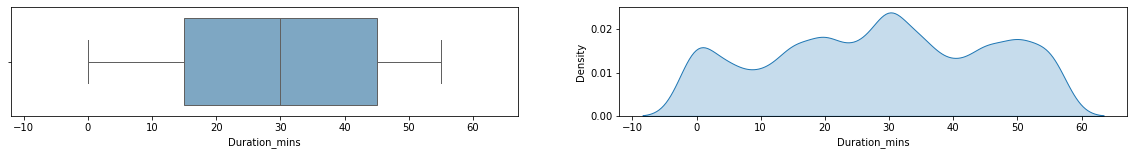

<Figure size 1440x144 with 0 Axes>

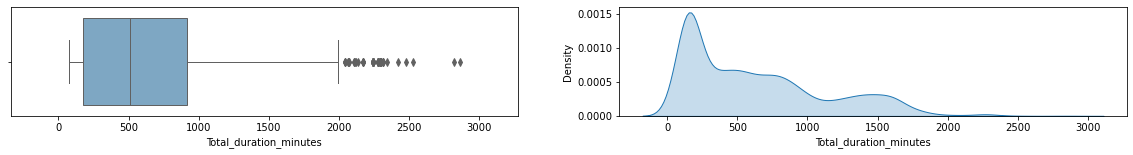

In [50]:
my_cols = ['Journey_day', 'Dep_hour', 'Dep_min', 'Arrival_hour',
       'Arrival_min', 'Duration_hours', 'Duration_mins',
       'Total_duration_minutes']

for i in my_cols:
    plt.figure()
    
    rcParams['figure.figsize'] = (20,2) 

    fig, (ax_box, ax_kde) = plt.subplots(ncols=2, sharex=True)
    
    plt.gca().set(xlabel= i,ylabel='Density')    
    sns.boxplot(flight_ticket[i], ax=ax_box , linewidth= 1.0, palette='PuBu')
    sns.kdeplot(flight_ticket[i], ax=ax_kde , fill=True, palette='PuBu')
    
    plt.show()

## As we can notice from prvious visualizations `Duration_hours` has High Postive Skewness.<br><br> And so is `Total_duration_minutes` which is the same of `Duration_hours` (same data multiplyed by 60).
### We can notice outliers in boxplot... But by data understanding (we can say this is not outliers of my data)
### The purpose of plotting boxplots here is only for showing skewness not outliers !!!

### Showing `Duration_hours` again before optimizing skewness : 

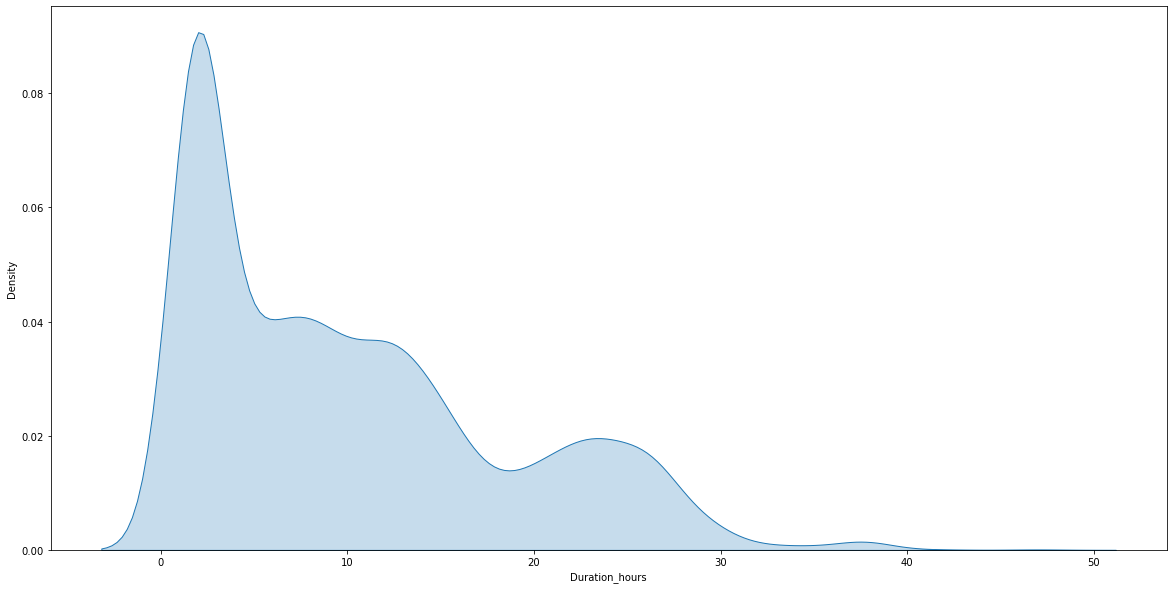

In [51]:
rcParams['figure.figsize'] = (20,10)

sns.kdeplot(flight_ticket['Duration_hours'], fill=True, palette='PuBu')
plt.show()

### Ok.... There is high skewness in both `Total_duration_minutes` and `Duration_hours` <br><br> (they are the same I made them for my insights but while the model one of them will be dropped)

# Note:
### We can also that the computer calculated high skewness for `Airline`  and `Destination`. <br><br> But I won't care because this data is categorical encoded to integers (so no optimazations on them !!)

### Now optimizing `Total_duration_minutes` and `Duration_hours` : 

In [52]:
flight_ticket['Duration_hours'] = np.log(flight_ticket['Duration_hours'])
flight_ticket['Total_duration_minutes'] = np.log(flight_ticket['Total_duration_minutes'])

test_ticket['Duration_hours'] = np.log(test_ticket['Duration_hours'])
test_ticket['Total_duration_minutes'] = np.log(test_ticket['Total_duration_minutes'])

changed_flight['Duration_hours'] = np.log(changed_flight['Duration_hours'])
changed_flight['Total_duration_minutes'] = np.log(changed_flight['Total_duration_minutes'])

changed_test['Duration_hours'] = np.log(changed_test['Duration_hours'])
changed_test['Total_duration_minutes'] = np.log(changed_test['Total_duration_minutes'])

In [53]:
flight_ticket.skew()

Price                     1.72
Journey_day               0.12
Journey_month            -0.38
Dep_hour                  0.10
Dep_min                   0.17
Arrival_hour             -0.39
Arrival_min               0.11
Duration_hours           -0.26
Duration_mins            -0.09
Total_duration_minutes   -0.16
dtype: float64

In [54]:
test_ticket.skew()

Journey_day               0.12
Journey_month            -0.39
Dep_hour                  0.14
Dep_min                   0.16
Arrival_hour             -0.32
Arrival_min               0.12
Duration_hours           -0.23
Duration_mins            -0.09
Total_duration_minutes   -0.13
dtype: float64

### Showing `Duration_hours` after optimizing skewness : 

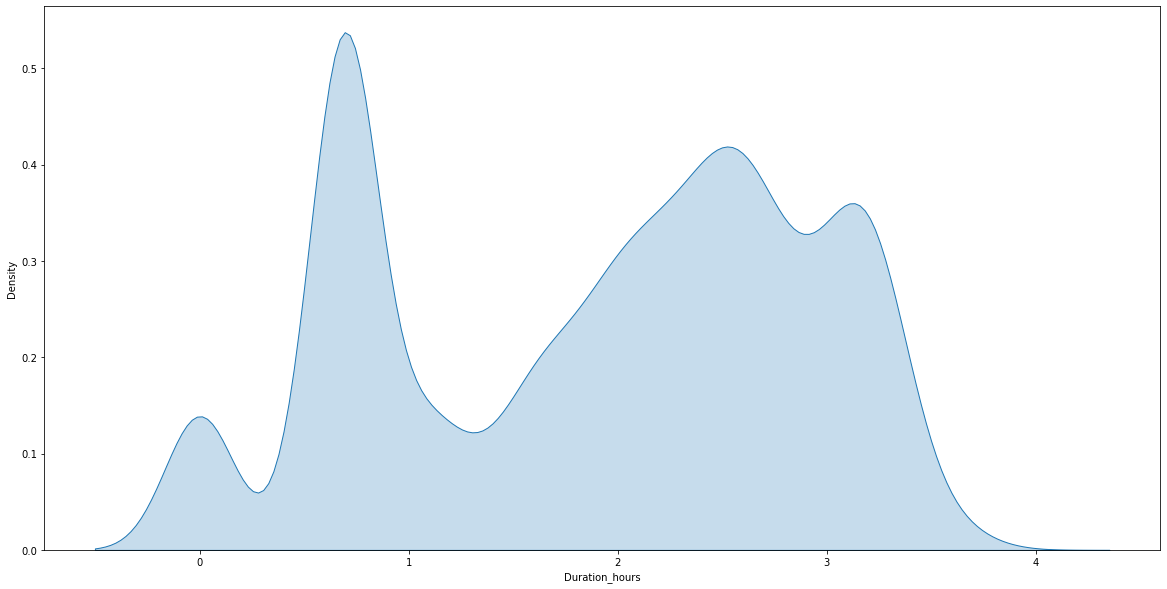

In [55]:
sns.kdeplot(flight_ticket['Duration_hours'], fill=True, palette='PuBu')
plt.show()

### Everything is alright for now :)
### No data skewed :)

## Now scaling the data : 

In [56]:
sc = StandardScaler()

features_train = changed_flight.drop('Price',axis=1)
y = changed_flight['Price']
dataset1 = sc.fit_transform(features_train)
x = pd.DataFrame(dataset1,columns=features_train.columns)

features_test = changed_test
dataset2 = sc.fit_transform(features_test)
x_to_test = pd.DataFrame(dataset2,columns=features_test.columns)

## Now I will have 3 data sets ready !!!. Which are : 
> - x : contains features data needed for training the model. <br><br>
> - y : contains price data needed for training the model. <br><br>
> - x_to_test : contains features data needed for testing the model.

# Finally !!! my data will be ready for the Machine Learning stage.

<h1><center><center><h1><h1><center><span style="color:#2189b5">Machine Learning Model Stage : </span><center><h1>

# Now for the fun part :)

### First I want to make a dummy model in which it should be a model with bad accuracy (so I can know that such accuracy will be my baseline)
### If I got an accuracy less than the accuracy of the dummy model this will show me that I have a problem in my data or in the model 

# I will chose `Linear Regression As A Dummy Model` because:
> - From data understanding data has no linear correlation. <br><br>
> - in the heat map I can notice that linear correlation is nearly zero. <br><br>
> - Linear Regression is a bad choose for a model (So it will be as a dummy model here)

<h1><center><span style="color:#2189b5">Dummy Model using Linear Regression : </span><center><h1>

In [57]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
LR = LinearRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)

print(Fore.LIGHTBLUE_EX + '\nScore of my dummy model is : ', r2_score(y_test, y_pred))
print(Fore.LIGHTBLUE_EX + '\n\nMean absolute error of my dummy model is : ', mean_absolute_error(y_test, y_pred))


Score of my dummy model is :  0.5758904503158098


Mean absolute error of my dummy model is :  2022.386015717811


## This score will be the worst score I should reach (it is my baseline).
## If I got score less than that... this means that there is an error in the model or the data.<br><br><br><br><br><br>

<h1><center><span style="color:#2189b5">Choosing My Machine Learning Models : </span><center><h1>

### One of the most booring things is choosing the appropriate algorthim for the data... <br><br>So there is a library that does so for us which is `lazypredict`

### I runed the library on my data on another notebook (I took 2 hours running) and saved data came from it as a csv file.<br> So here I will just write the code as comments and I will show screenshoot of it and I will import the csv file

In [58]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
#from lazypredict.Supervised import LazyRegressor
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#models, predictions = reg.fit(X_train, X_test, y_train, y_test)
#models.head(20)

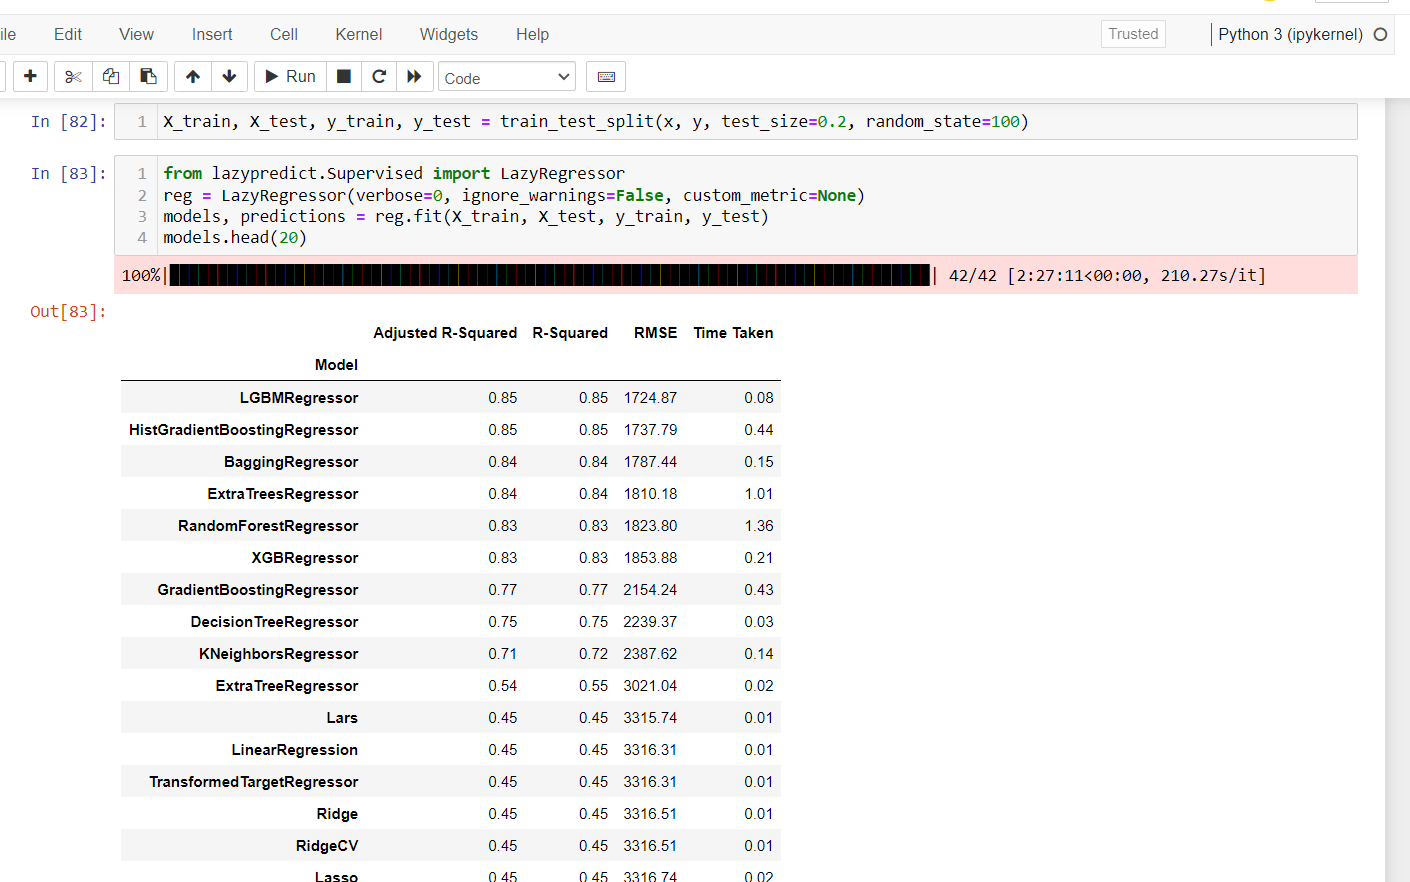

In [59]:
best_models_by_lazypredict = pd.read_csv('Datasets/best_models_by_lazypredict.csv')
best_models_by_lazypredict.head(10)

,Model,Adjusted R-Squared,R-Squared,RMSE,Time Taken
0,LGBMRegressor,0.85,0.85,1724.87,0.08
1,HistGradientBoostingRegressor,0.85,0.85,1737.79,0.44
2,BaggingRegressor,0.84,0.84,1787.44,0.15
3,ExtraTreesRegressor,0.84,0.84,1810.18,1.01
4,RandomForestRegressor,0.83,0.83,1823.80,1.36
5,XGBRegressor,0.83,0.83,1853.88,0.21
6,GradientBoostingRegressor,0.77,0.77,2154.24,0.43
7,DecisionTreeRegressor,0.75,0.75,2239.37,0.03
8,KNeighborsRegressor,0.71,0.72,2387.62,0.14
9,ExtraTreeRegressor,0.54,0.55,3021.04,0.02


## I will try to train from this models and see best results :) <br><br><br><br>

<h1><center><span style="color:#2189b5">Training My Machine Learning Models : </span><center><h1>

## Using models I know I will make a model pipeline :

In [60]:
import lightgbm as ltb
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

pipeline = []

pipeline.append(RandomForestRegressor())
pipeline.append(GradientBoostingRegressor())
pipeline.append(XGBRegressor())
pipeline.append(ltb.LGBMRegressor())
pipeline.append(HistGradientBoostingRegressor())
pipeline.append(ExtraTreesRegressor())
pipeline.append(KNeighborsRegressor(n_neighbors=5))
pipeline.append(BaggingRegressor(base_estimator=SVR(), n_estimators=10, random_state=0))
pipeline.append(linear_model.Lars(n_nonzero_coefs=1, normalize=False))

In [61]:
model_name = ['RandomForestRegressor','GradientBoostingRegressor','XGBRegressor','LGBMRegressor',
              'HistGradientBoostingRegressor','ExtraTreesRegressor','KNeighborsRegressor'
             ,'BaggingRegressor','Lars']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

count = 0

for model in pipeline: 
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    print(Fore.LIGHTBLUE_EX,model_name[count],': mean absolute error ------->  ', mean_absolute_error(y_test,pred))
    count = count + 1

 RandomForestRegressor : mean absolute error ------->   735.6646907404051
 GradientBoostingRegressor : mean absolute error ------->   1262.1213355899506
 XGBRegressor : mean absolute error ------->   770.2275796235931
 LGBMRegressor : mean absolute error ------->   938.9577133498153
 HistGradientBoostingRegressor : mean absolute error ------->   940.9235967581642
 ExtraTreesRegressor : mean absolute error ------->   712.6614468399916
 KNeighborsRegressor : mean absolute error ------->   1152.8180088776157
 BaggingRegressor : mean absolute error ------->   3398.8059636525522
 Lars : mean absolute error ------->   2999.7220924489075


#### Now I can see that best models score for this data is on `RandomForestRegressor` and `ExtraTreesRegressor`...
#### So I submitted both of them on kaggle (but `RandomForestRegressor` gave me slightly better accuracy)<br><br> So I will use random forest as my Algorithm

## So here I will train using `RandomForestRegressor` :

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

Rf = RandomForestRegressor()
Rf.fit(x_train,y_train)
pred = Rf.predict(x_test)


### Making a color palette : 

In [63]:
my_palette = sns.color_palette("PuBu", 2)
my_palette

[(0.7058823529411765, 0.7673202614379085, 0.873202614379085),
 (0.1477124183006536, 0.5228758169934641, 0.7320261437908496)]

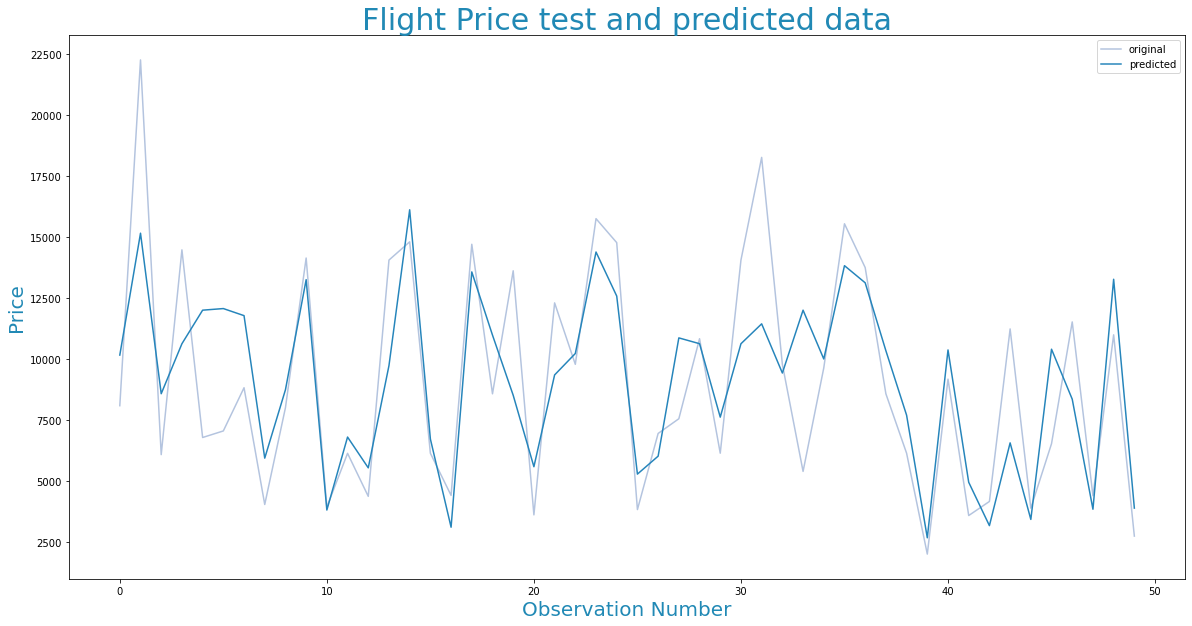

In [64]:

number_of_observations=50

x_ax = range(len(y_test[:number_of_observations]))

plt.plot(x_ax, y_test[:number_of_observations], label="original",color=my_palette[0])
plt.plot(x_ax, y_pred[:number_of_observations], label="predicted",color=my_palette[1])

plt.title("Flight Price test and predicted data",size=30,color='#2189b5')
plt.xlabel('Observation Number',size=20,color='#2189b5')
plt.ylabel('Price',size=20,color='#2189b5')
plt.legend()

plt.show()

# Our models on Kaggle :

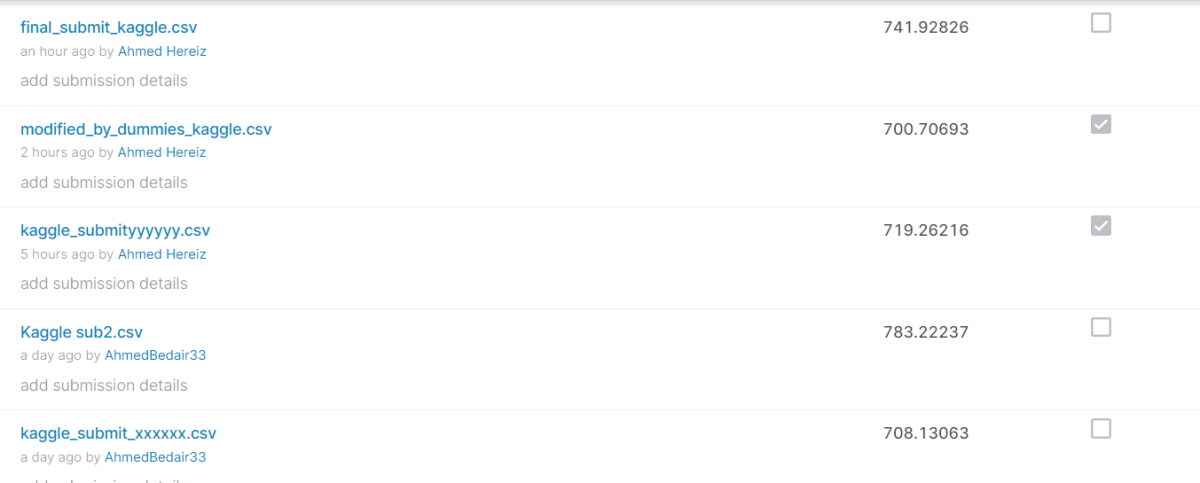

# The End